In [ ]:
import numpy as np
np.random.seed(123)

import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf
#tf.set_random_seed(1234)

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [ ]:
from google.colab import files

import pandas as pd

upload = files.upload()

In [ ]:
df1 = pd.read_csv('Newsdataser.csv',skiprows = 15)
df1.head()

,YEAR,MO,DY,HR,PS,WS10M,WD10M,WS50M,RH2M,PRECTOTCORR,T2M
0,2020,5,1,0,101.05,2.49,264.79,3.32,90.12,0.08,26.15
1,2020,5,1,1,100.97,2.31,260.06,3.05,90.25,0.12,26.02
2,2020,5,1,2,100.92,2.20,254.14,2.85,90.19,0.19,25.91
3,2020,5,1,3,100.90,2.23,250.36,2.88,90.00,0.19,25.87
4,2020,5,1,4,100.92,2.24,247.20,2.88,90.00,0.15,25.83


Percentage of Missing data per feature 

In [ ]:
df1.isnull().sum() * 100 / len(df1)

YEAR           0.0
MO             0.0
DY             0.0
HR             0.0
PS             0.0
WS10M          0.0
WD10M          0.0
WS50M          0.0
RH2M           0.0
PRECTOTCORR    0.0
T2M            0.0
dtype: float64

In [ ]:
df1['WS10M'] = df1['WS10M']*np.cos(df1['WD10M']*np.pi/180)
df1['WD10M'] = df1['WS10M']*np.sin(df1['WD10M']*np.pi/180)
df3 = df1.rename(columns = {'WS10M': 'Wx', 'WD10M': 'Wy'}, inplace = False)
# Print out df2_tidy
df3

,YEAR,MO,DY,HR,PS,Wx,Wy,WS50M,RH2M,PRECTOTCORR,T2M
0,2020,5,1,0,101.05,-0.226106,-0.000889,3.32,90.12,0.08,26.15
1,2020,5,1,1,100.97,-0.398735,-0.002733,3.05,90.25,0.12,26.02
2,2020,5,1,2,100.92,-0.601202,-0.006068,2.85,90.19,0.19,25.91
3,2020,5,1,3,100.90,-0.749467,-0.009234,2.88,90.00,0.19,25.87
4,2020,5,1,4,100.92,-0.867950,-0.012122,2.88,90.00,0.15,25.83
...,...,...,...,...,...,...,...,...,...,...,...
2203,2020,7,31,19,101.02,-3.573617,-0.085421,5.43,89.50,0.00,23.66
2204,2020,7,31,20,101.09,-3.688488,-0.086270,5.52,90.19,0.00,23.57
2205,2020,7,31,21,101.14,-3.709723,-0.083896,5.54,90.94,0.00,23.50
2206,2020,7,31,22,101.14,-3.715740,-0.083182,5.56,91.56,0.00,23.46


Selection of the features/ We are removing the relative humidity because it is not significant for the temperature and the precipitation that we are trying to eaxplain.

In [ ]:
df2 =  df3[ ['PS', 'Wx', 'Wy', 'WS50M', 'PRECTOTCORR', 'T2M']  ]
df2

,PS,Wx,Wy,WS50M,PRECTOTCORR,T2M
0,101.05,-0.226106,-0.000889,3.32,0.08,26.15
1,100.97,-0.398735,-0.002733,3.05,0.12,26.02
2,100.92,-0.601202,-0.006068,2.85,0.19,25.91
3,100.90,-0.749467,-0.009234,2.88,0.19,25.87
4,100.92,-0.867950,-0.012122,2.88,0.15,25.83
...,...,...,...,...,...,...
2203,101.02,-3.573617,-0.085421,5.43,0.00,23.66
2204,101.09,-3.688488,-0.086270,5.52,0.00,23.57
2205,101.14,-3.709723,-0.083896,5.54,0.00,23.50
2206,101.14,-3.715740,-0.083182,5.56,0.00,23.46


In [ ]:
def ReScale(data, a):
    data_avg = data.mean()
    scaled_data = a*(data - data_avg)
    return scaled_data  

In [ ]:
df2 = ReScale(df2 , 0.5)
#df2.drop(['WD10M' , 'PS' ] , axis = 1 , inplace  =  True)
df2.head()

,PS,Wx,Wy,WS50M,PRECTOTCORR,T2M
0,0.061791,1.148880,0.034060,-0.564717,-0.089312,0.077097
1,0.021791,1.062566,0.033138,-0.699717,-0.069312,0.012097
2,-0.003209,0.961332,0.031470,-0.799717,-0.034312,-0.042903
3,-0.013209,0.887200,0.029888,-0.784717,-0.034312,-0.062903
4,-0.003209,0.827958,0.028444,-0.784717,-0.054312,-0.082903


In [ ]:
shifts =  [df2.shift(11) , df2.shift(10) ,df2.shift(9) ,
           df2.shift(8),df2.shift(7) , df2.shift(6),
           df2.shift(5) , df2.shift(4), df2.shift(3), ]

In [ ]:
def sliding_windows(data, window_size):#, forecast_over, shift):
    num_batches = len(data) - window_size + 1
    x = []
    for i in range(num_batches):
        _x = data[ i:i+window_size]
        x.append(_x)
    
    #x.append(data[-window_size:,:])
    return np.array(x)

In [ ]:
time_steps_provider = 12

In [ ]:
framework = sliding_windows(df2, time_steps_provider)[:-1]  #4 here is the loopback
framework

array([[[ 0.06179121,  1.14943317, -0.56809627, -0.56471694,
         -0.08931159,  0.07709692],
        [ 0.02179121,  1.06311474, -0.48430353, -0.69971694,
         -0.06931159,  0.01209692],
        [-0.00320879,  0.96187063, -0.39151042, -0.79971694,
         -0.03431159, -0.04290308],
        ...,
        [ 0.09679121,  0.22135351, -0.15650111, -0.86471694,
         -0.10431159,  1.35209692],
        [ 0.08179121,  0.03290594, -0.23343651, -0.74971694,
         -0.10931159,  1.64709692],
        [ 0.05679121, -0.20791963, -0.39004647, -0.55971694,
         -0.10431159,  1.84709692]],

       [[ 0.02179121,  1.06311474, -0.48430353, -0.69971694,
         -0.06931159,  0.01209692],
        [-0.00320879,  0.96187063, -0.39151042, -0.79971694,
         -0.03431159, -0.04290308],
        [-0.01320879,  0.88772541, -0.32772394, -0.78471694,
         -0.03431159, -0.06290308],
        ...,
        [ 0.08179121,  0.03290594, -0.23343651, -0.74971694,
         -0.10931159,  1.64709692],
  

In [ ]:
outputs1 = df2['T2M'][time_steps_provider:].values
outputs2 = df2['PRECTOTCORR'][time_steps_provider:].values

Our training data

In [ ]:
train_points = int(0.98*len(framework)) #0.90 is the proportion of the training set 
train_points

2152

In [ ]:
test_points = len(framework) - train_pointsClass
test_points

44

In [ ]:
#n_points = len(df_new)
X2_train, X2_test = framework[:train_points] , framework[train_points:]
y2_train, y2_test = outputs2[:train_points],  outputs2[train_points:]

In [ ]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
keras.backend.clear_session()

X2_train = X2_train.reshape(X2_train.shape[0],4, 11)
X2_test = X2_test.reshape(X2_test.shape[0],4, 11)
print(X2_train.shape)
print(X2_test.shape)

In [ ]:
model = Sequential()
model.add(SimpleRNN(units=100, input_shape=(X2_train.shape[1], X2_train.shape[2]))) #input_shape takes time steps and features
#model.add(SimpleRNN(units=10))#, input_shape=(X2_train.shape[1], X2_train.shape[2])))
#model.add(SimpleRNN(units=10))#, input_shape=(X2_train.shape[1], X2_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='sgd')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 100)               10700     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,801
Trainable params: 10,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epoch = 10

model.fit(X2_train, y2_train, epochs=nb_epoch)

Epoch 1/10
68/68 [==============================] - 2s 14ms/step - loss: 0.0614
Epoch 2/10
68/68 [==============================] - 1s 14ms/step - loss: 0.0253
Epoch 3/10
68/68 [==============================] - 1s 14ms/step - loss: 0.0185
Epoch 4/10
68/68 [==============================] - 1s 14ms/step - loss: 0.0150
Epoch 5/10
68/68 [==============================] - 1s 15ms/step - loss: 0.0129
Epoch 6/10
68/68 [==============================] - 1s 15ms/step - loss: 0.0114
Epoch 7/10
68/68 [==============================] - 1s 14ms/step - loss: 0.0104
Epoch 8/10
68/68 [==============================] - 1s 14ms/step - loss: 0.0098
Epoch 9/10
68/68 [==============================] - 1s 15ms/step - loss: 0.0091
Epoch 10/10
68/68 [==============================] - 1s 14ms/step - loss: 0.0087


In [ ]:
y2_train_pred = model.predict(X2_train)
y2_test_pred = model.predict(X2_test)

In [ ]:
mean_squared_error(y2_train_pred , y2_train)

0.0031150169790787707

In [ ]:
mean_squared_error(y2_test_pred , y2_test)

0.0004579720401257979

Text(0.5, 1.0, 'Comparison of predicted training precipitation with actual precipicipitation')

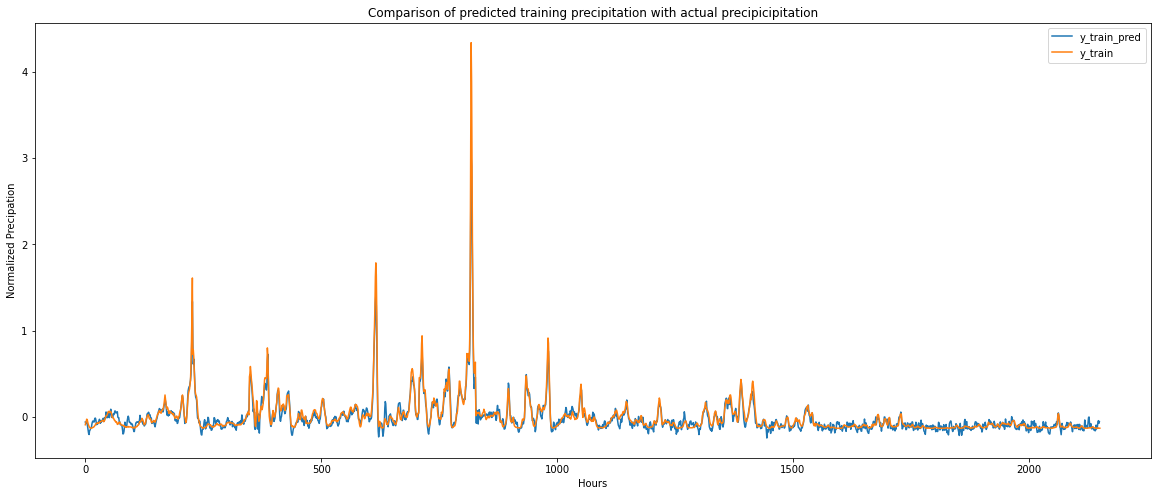

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y2_train_pred[1:] , label ='y_train_pred')
plt.plot(y2_train , label ='y_train')
plt.legend(loc='upper right')
plt.ylabel('Normalized Precipation')
plt.xlabel('Hours')
plt.title('Comparison of predicted training precipitation with actual precipicipitation')

Text(0.5, 1.0, 'Comparison of predicted testing Temperature with actual Temperature')

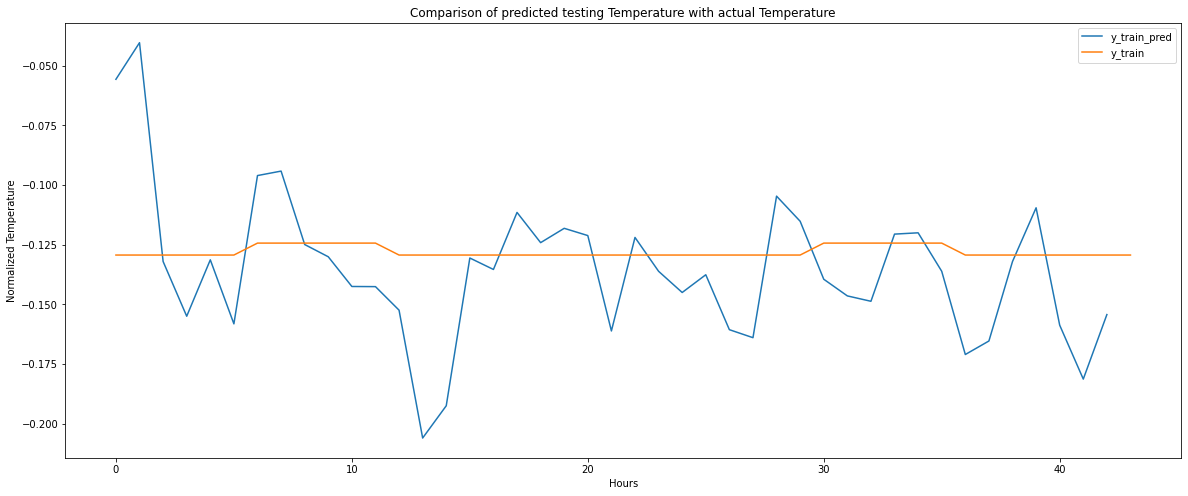

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y2_test_pred[1:] , label ='y_train_pred')
plt.plot(y2_test , label ='y_train')
plt.legend(loc='upper right')
plt.ylabel('Normalized Precipitation')
plt.xlabel('Hours')
plt.title('Comparison of predicted testing Precipitation with actual Precipitation')

Text(0.5, 1.0, 'Comparison of predicted testing precipitation with actual precipitation')

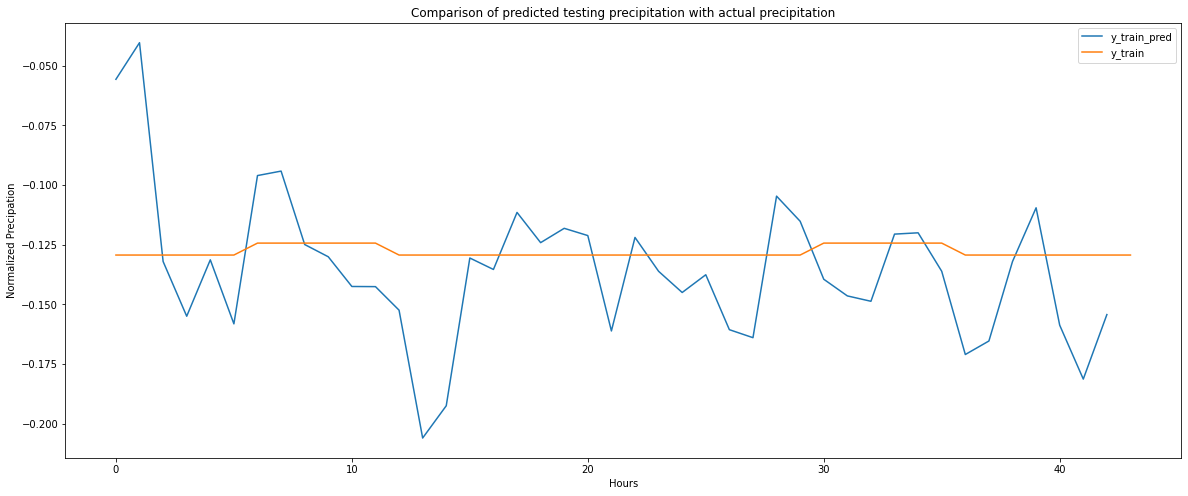

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y2_test_pred[1:] , label ='y_train_pred')
plt.plot(y2_test , label ='y_train')
plt.legend(loc='upper right')
plt.ylabel('Normalized Precipation')
plt.xlabel('Hours')
plt.title('Comparison of predicted testing precipitation with actual precipitation')

In [ ]:
from keras.layers import LSTM

In [ ]:
model1 = Sequential()
model1.add(LSTM(units=20, input_shape=(X2_train.shape[1], X2_train.shape[2]))) #input_shape takes time steps and features
#model1.add(LSTM(units=10))#, input_shape=(X2_train.shape[1], X2_train.shape[2])))
#model.add(SimpleRNN(units=10))#, input_shape=(X2_train.shape[1], X2_train.shape[2])))
model1.add(Dense(1))

model1.compile(loss='mean_squared_error', optimizer='sgd')

model1.summary()

ValueError: ignored

In [ ]:
nb_epoch = 50

model1.fit(X2_train, y2_train, epochs=nb_epoch)

Epoch 1/50
68/68 [==============================] - 2s 5ms/step - loss: 12.2402
Epoch 2/50
68/68 [==============================] - 0s 5ms/step - loss: 2.8606
Epoch 3/50
68/68 [==============================] - 0s 5ms/step - loss: 2.8532
Epoch 4/50
68/68 [==============================] - 0s 5ms/step - loss: 2.9121
Epoch 5/50
68/68 [==============================] - 0s 6ms/step - loss: 2.8518
Epoch 6/50
68/68 [==============================] - 0s 5ms/step - loss: 2.8372
Epoch 7/50
68/68 [==============================] - 0s 5ms/step - loss: 2.8597
Epoch 8/50
68/68 [==============================] - 0s 5ms/step - loss: 2.8779
Epoch 9/50
68/68 [==============================] - 0s 5ms/step - loss: 2.8231
Epoch 10/50
68/68 [==============================] - 0s 5ms/step - loss: 2.8742
Epoch 11/50
68/68 [==============================] - 0s 5ms/step - loss: 2.8675
Epoch 12/50
68/68 [==============================] - 0s 5ms/step - loss: 2.8910
Epoch 13/50
68/68 [=============================

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df1.head()

,YEAR,MO,DY,HR,PS,WS10M,WD10M,WS50M,RH2M,PRECTOTCORR,T2M
0,2020,5,1,0,101.05,2.49,264.79,3.32,90.12,0.08,26.15
1,2020,5,1,1,100.97,2.31,260.06,3.05,90.25,0.12,26.02
2,2020,5,1,2,100.92,2.20,254.14,2.85,90.19,0.19,25.91
3,2020,5,1,3,100.90,2.23,250.36,2.88,90.00,0.19,25.87
4,2020,5,1,4,100.92,2.24,247.20,2.88,90.00,0.15,25.83


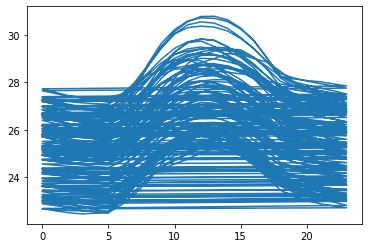

In [ ]:
plt.plot(df1['HR'], df1['T2M'])